In [10]:
import pathlib as pl
import pandas
import matplotlib.pyplot as plt

import flopy
from defaults import *

Get the working dirs

In [11]:
parallel_dir = get_parallel_dir()
base_dir = get_base_dir()

Load the parallel simulation from disk

In [12]:
parallel_sim = flopy.mf6.MFSimulation.load(sim_ws=parallel_dir, verbosity_level=0)
nr_models = len(parallel_sim.model_names)

### Read the convergence data from the CSVs

This will get the reference data

In [13]:
csv_inner_base = pl.Path.cwd().joinpath(base_dir).joinpath("inner.csv")
assert pl.Path.is_file(csv_inner_base)

And for parallel we have multiple files, one per process

In [14]:
csv_inner_par = [pl.Path.cwd().joinpath(parallel_dir).joinpath(f"inner.p{irank}.csv") 
                 for irank in range(nr_models)]
assert pl.Path.is_file(csv_inner_par[-1])

Read them from disk with the csv read utility in `pandas`

In [15]:
df_base = pandas.read_csv(csv_inner_base)
df_par = [pandas.read_csv(f) for f in csv_inner_par]

total_inners_base = df_base.iloc[-1]["total_inner_iterations"]
total_inners_par = df_par[0].iloc[-1]["total_inner_iterations"]

Check on the total number of inner iterations

In [16]:
print("Total inner iterations base:", total_inners_base, ", parallel:", total_inners_par)

Total inner iterations base: 382.0 , parallel: 404.0


Set the variable that we are plotting

In [17]:
plot_variable = "solution_inner_dvmax"

### Plot the convergence behavior
Include DVClose and the total nr. of inners from the base simulation to plot as a reference in the figure

In [18]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

Text(0, 0.5, 'solution_inner_dvmax')

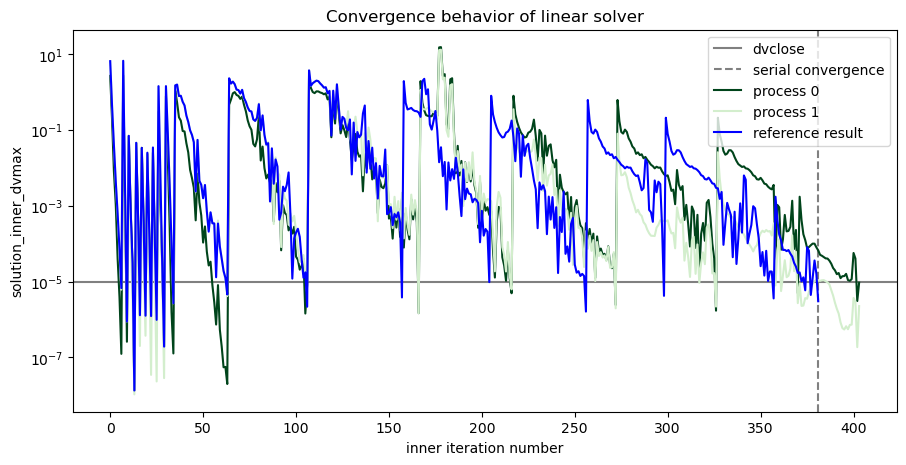

In [19]:
fig = plt.figure(figsize=(1.5*figwidth,0.7*figheight))
colors = plt.cm.Greens(np.linspace(1.0,0.2,nr_models))

# get dvclose from the IMS package
dvclose = parallel_sim.get_package("IMS").inner_dvclose.data
plt.axhline(dvclose, color="grey", label="dvclose")
plt.axvline(total_inners_base - 1, color="grey", linestyle="dashed", label="serial convergence")

for i, df in enumerate(df_par):
  dvmax = abs(df[plot_variable])
  plt.plot(dvmax, label=f"process {i}", color=colors[i])

dvmax = abs(df_base[plot_variable])
plt.plot(dvmax, label='reference result', color="blue")

plt.yscale("log")
plt.legend()
plt.title("Convergence behavior of linear solver")
plt.xlabel("inner iteration number")
plt.ylabel(plot_variable)

### Possible next steps
* Demo: new files and diagnostics with parallel MODFLOW
* Start from the splitting in [notebook 2](./step2_split_watershed.ipynb) and change the method to using the Metis library and run all subsequent notebooks
* Change the number of domains in [notebook 1](./step1_watershed.ipynb) and run everything after again
* The default problem is still relatively small for parallel scaling. Increase the size of the problem in [notebook 1](./step1_watershed.ipynb) and see how the run times of serial and parallel compare
* Make the hclose parameter (the solver tolerance) smaller in [notebook 1](./step1_watershed.ipynb) and confirm that the head difference plots between the base reference and the parallel results are indeed getting smaller accordingly